<a href="https://colab.research.google.com/github/AmedeeRoy/BirdDL/blob/main/Dive_Prediction_DeepNetwork_MatrixDistance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Seabird Diving Behaviour with GPS data

Supervized Learning on Distance Matrix

In [ ]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
%cd drive/My\ Drive/BirdDL

/content/drive/My Drive/BirdDL


In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython
import datetime
import random
import pickle
import trip

In [ ]:
# connect to database
conn = sqlite3.connect('/content/drive/My Drive/data/seabirdbank.db')
# conn = sqlite3.connect('/home/amdroy/MEGA/DATA/seabirdbank.db')

In [ ]:
request = "SELECT \
            trip.id as trip, gps.datetime, gps.lon, gps.lat\
            FROM gps \
            INNER JOIN trip ON gps.trip = trip.id \
            INNER JOIN bird ON trip.bird = bird.id \
            WHERE trip.file_gps IS NOT NULL \
            AND trip.file_tdr IS NOT NULL \
            AND (bird.fieldwork = 'P1108' OR bird.fieldwork = 'P1111' \
                OR bird.fieldwork = 'P1112' OR bird.fieldwork = 'P1113') \
            AND bird.species = 'SV'"

# substr(bird.fieldwork,1,1) = 'P'

gps = pd.read_sql_query(request, conn)

# check duplicated datetime in GPS trip
idx = gps.index[gps.loc[:, 'trip':'datetime'].duplicated(keep=False)]
idx_drop = [idx[i] for i in range(0, len(idx), 2)]
gps = gps.drop(idx_drop)


request = "SELECT \
            trip.id as trip, tdr.datetime, tdr.pressure \
            FROM tdr \
            INNER JOIN trip ON tdr.trip = trip.id \
            INNER JOIN bird ON trip.bird = bird.id \
            WHERE trip.file_gps IS NOT NULL \
            AND trip.file_tdr IS NOT NULL \
            AND (bird.fieldwork = 'P1108' OR bird.fieldwork = 'P1111' \
                OR bird.fieldwork = 'P1112' OR bird.fieldwork = 'P1113') \
            AND bird.species = 'SV'"

# WHERE substr(bird.fieldwork,1,1) = 'P' 

tdr = pd.read_sql_query(request, conn)
tdr['datetime'] = pd.to_datetime(tdr['datetime'], format='%Y-%m-%d %H:%M:%S')
gps['datetime'] = pd.to_datetime(gps['datetime'], format='%Y-%m-%d %H:%M:%S')

df = pd.merge(tdr, gps, on=['trip', 'datetime'], how='left')

# check NaN and fill with interpolations
[i for i, x in enumerate(df['lon'].isna()) if x]


df['lon'] = df['lon'].interpolate(method='polynomial', order=2)
df['lat'] = df['lat'].interpolate(method='polynomial', order=2)


bad_trip = ['P1111_9_SV_T1', 'P1111_13_SV_T6', 'P1111_41_SV_T2', 'P1111_46_SV_T5', 'P1111_52_SV_T1',
            'P1112_4_SV_T2', 'P1112_26_SV_T5', 'P1112_36_SV_T1', 'P1112_36_SV_T2', 'P1113_41_SV_T3',
           'P1113_50_SV_T2']

no_loop = ['P1112_26_SV_T1', 'P1112_26_SV_T2', 'P1112_26_SV_T3', 'P1112_26_SV_T4']


### remove bad data
idx = df.index[[(t in bad_trip or t in no_loop) for t in df.trip]]
df = df.drop(idx)

df

,trip,datetime,pressure,lon,lat
0,P1108_4_SV_T1,2008-11-25 13:00:35,-0.35,-77.264128,-11.773317
1,P1108_4_SV_T1,2008-11-25 13:00:36,-0.38,-77.264118,-11.773235
2,P1108_4_SV_T1,2008-11-25 13:00:37,-0.35,-77.264098,-11.773152
3,P1108_4_SV_T1,2008-11-25 13:00:38,-0.29,-77.264113,-11.773060
4,P1108_4_SV_T1,2008-11-25 13:00:39,-0.29,-77.264142,-11.772955
...,...,...,...,...,...
1035988,P1113_50_SV_T1,2013-11-24 13:09:17,-1.01,-77.264229,-11.773601
1035989,P1113_50_SV_T1,2013-11-24 13:09:18,-1.07,-77.264221,-11.773701
1035990,P1113_50_SV_T1,2013-11-24 13:09:19,-1.07,-77.264191,-11.773771
1035991,P1113_50_SV_T1,2013-11-24 13:09:20,-1.01,-77.264168,-11.773826


In [ ]:
%%time
trajs = []
threshold = 1
radius = 500
n = 1
for k in df.trip.unique():
    df_trip = df[df.trip == k]
    
    t = trip.Trip(df_trip)
    
    # add variables
    t.add_dive(threshold)
    t.add_step()
    t.add_cap()
    t.add_direction()
    t.df['cos_cap'] = np.cos(t.df.cap)
    t.df['sin_cap'] = np.sin(t.df.cap)

    # standardized trajectories
    t.standardize(('step', 'direction'))
    t.standardize_minmax(('lon', 'lat'))

    trajs.append(t.df)
    
    IPython.display.clear_output(wait=True)
    print('Trip [{}/{}]'.format(n, len(df.trip.unique())))
    n+=1

Trip [170/170]
CPU times: user 19.8 s, sys: 301 ms, total: 20.1 s
Wall time: 20 s


In [ ]:
test_trajs_idx = np.random.randint(0, len(df.trip.unique()), 30)

test_trajs = [trajs[i] for i in test_trajs_idx]
train_trajs = [trajs[i] for i in range(len(df.trip.unique())) if i not in test_trajs_idx]

## Neural Network

In [ ]:
# pytorch materials
import torch
from torch import nn
from torch import optim
import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [ ]:
class Sampler:
    def __init__(self, trajs, epoch_input, epoch_output, batch_size, input_var):
      # raw trajectories
      self.trajs = trajs
      self.n = len(trajs)
      # sample input specificities
      self.epoch_input = epoch_input
      self.epoch_output = epoch_output
      self.epoch_ratio = round(epoch_input/epoch_output)
      self.batch_size = batch_size
      self.input_var = input_var


    def sample(self):
      input_batch = []
      output_batch = []
      for i in range(self.batch_size):
        # look for a long trip
        dt = []
        while len(dt) < self.epoch_input :
            traj_idx = np.random.randint(self.n)
            dt = self.trajs[traj_idx]

        # select part of this trip
        epoch_idx = np.random.randint(2, len(dt)-self.epoch_input )

        input_trajs = dt.loc[epoch_idx:epoch_idx+self.epoch_input-1, self.input_var]
        output_trajs = dt.loc[epoch_idx:epoch_idx+self.epoch_input-1, 'dive']

        # change resolution
        output = [np.max(output_trajs[i:i+11]) for i in range(len(output_trajs)) if i%10==0]

        # add it to batch
        input_batch.append(input_trajs.to_numpy().T)
        output_batch.append(np.array(output))

      # convert to tensor
      input_batch = torch.FloatTensor(input_batch)
      output_batch = torch.FloatTensor(output_batch)

      return (input_batch, output_batch)

# torch.diagonal(input, offset=0, dim1=0, dim2=1)
# torch.diag(input, diagonal=0, *, out=None) 

def pairwise_distances(x, y=None):
    '''
    Input: x is a Nxd matrix
           y is an optional Mxd matirx
    Output: dist is a NxM matrix where dist[i,j] is the square norm between x[i,:] and y[j,:]
            if y is not given then use 'y=x'.
    i.e. dist[i,j] = ||x[i,:]-y[j,:]||^2
    '''
    x_norm = (x**2).sum(1).view(-1, 1)
    if y is not None:
        y_t = torch.transpose(y, 0, 1)
        y_norm = (y**2).sum(1).view(1, -1)
    else:
        y_t = torch.transpose(x, 0, 1)
        y_norm = x_norm.view(1, -1)
    
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
    # Ensure diagonal is zero if x=y
    # if y is None:
    #     dist = dist - torch.diag(dist.diag)
    return torch.clamp(dist, 0.0, np.inf)

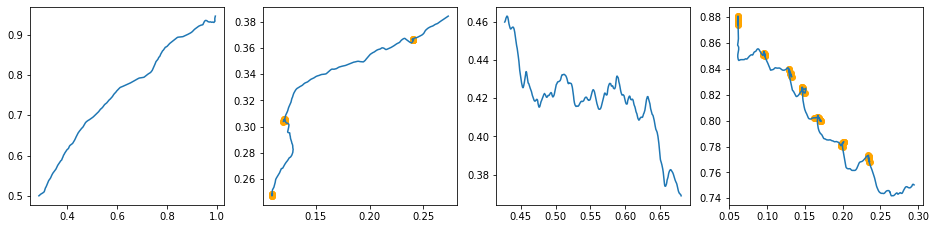

In [ ]:
# Hyperparameters
epoch_input = 600
epoch_output = 60
batch_size = 4
learning_rate = 0.01
input_var = ('lon_std_mm', 'lat_std_mm') # , 'step_std', 'direction_std', 'cos_cap', 'sin_cap')

train = Sampler(train_trajs, epoch_input, epoch_output, batch_size, input_var)
test = Sampler(test_trajs, epoch_input, epoch_output, batch_size, input_var)


(x, y) = train.sample()

plt.figure(figsize=(16, 8))
for i in range(batch_size):
    lon = x.numpy()[i][0]
    lat = x.numpy()[i][1]

    real = y.numpy()[i]
    real = [real[i] for i in range(len(real)) for k in range(10) ]

    plt.subplot(2, 4, i+1)
    

    plt.subplot(2, 4, i+5)
    plt.plot(lon, lat)
    plt.scatter(lon[np.where(real)], lat[np.where(real)], c='orange')

In [ ]:
x.size()

torch.Size([4, 2, 600])

In [ ]:
pairwise_distances(x).size()

RuntimeError: ignored

In [ ]:
### DATALOADER
nb_test = 1000

dataset_test = []
for i in range(nb_test):
    (x, y, z) = test.sample_one()
    dataset_test.append((x,y))
    if i%100 == 0:
      print('[{}/{}]'.format(i, nb_test))


test_loader = DataLoader(dataset_test, batch_size=batch_size, drop_last=True)

[0/1000]
[100/1000]
[200/1000]
[300/1000]
[400/1000]
[500/1000]
[600/1000]
[700/1000]
[800/1000]
[900/1000]


In [ ]:
# ### DATALOADER
nb_train = 10000

# dataset_train = []
# for i in range(nb_train):
#     (x, y, z) = train.sample_one()
#     dataset_train.append((x,y))
#     if i%1000 == 0:
#       print('[{}/{}]'.format(i, nb_train))


# train_loader = DataLoader(dataset_train, batch_size=batch_size, drop_last=True)

In [ ]:
# class ConvNet(nn.Module):
#     def __init__(self):
#         super(ConvNet, self).__init__()
        
#         ## operation on diagonal with distinct kernel  -------------------------------------------
#         self.diag_cnn_1 = nn.Sequential(
#             nn.BatchNorm2d(1),
#             nn.Conv2d(1, 1, kernel_size = 21, stride = 1, padding = 10, dilation = 1),
#             nn.ReLU(),
#             nn.Conv2d(1, 1, kernel_size = 21, stride = 1, padding = 10, dilation = 1),
#             nn.ReLU()
#         )

#         self.diag_cnn_2 = nn.Sequential(
#             nn.BatchNorm2d(1),
#             nn.Conv2d(1, 1, kernel_size = 41, stride = 1, padding = 20, dilation = 1),
#             nn.ReLU(),
#             nn.Conv2d(1, 1, kernel_size = 41, stride = 1, padding = 20, dilation = 1),
#             nn.ReLU()
#         )


#         self.diag_cnn_3 = nn.Sequential(
#             nn.BatchNorm2d(1),
#             nn.Conv2d(1, 1, kernel_size = 61, stride = 1, padding = 30, dilation = 1),
#             nn.ReLU(),
#             nn.Conv2d(1, 1, kernel_size = 61, stride = 1, padding = 30, dilation = 1),
#             nn.ReLU()
#         )
                
       
#         ## operation on timeseries -------------------------------------------------
#         self.sigmoid = nn.Sequential(
#             nn.Sigmoid()
#         ) 
                
#     def forward(self, x):
#         # CNN
#         out_1 = self.diag_cnn_1(x)
#         out_2 = self.diag_cnn_2(x)
#         out_3 = self.diag_cnn_3(x)

#         out_1 = torch.diagonal(out_1, 0, 2, 3)
#         out_2 = torch.diagonal(out_2, 0, 2, 3)
#         out_3 = torch.diagonal(out_3, 0, 2, 3)


#         out = torch.cat([out_1, out_2, out_3])

#         # out = self.im_pooling_1(out)
#         # out = self.im_cnn_2(out)
#         # out = self.im_pooling_2(out)
#         # out = self.im_cnn_3(out)
#         # out = self.im_pooling_3(out)

#         # Image to time-series
#         out = torch.sum(out, dim = 2)
#         out = self.sigmoid(out)

#         out = out.reshape((batch_size, 1, 1, epoch_output))

#         return out


In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        ## operation on diagonal with distinct kernel  -------------------------------------------
        self.im_cnn_1 = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 1, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU()
        )

        self.im_pooling_1 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 50, stride = 2, padding = 24, dilation = 1),
            nn.BatchNorm2d(1)
        )

        self.im_cnn_2 = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU()
        )

        self.im_pooling_2 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 15, stride = 2, padding = 7, dilation = 1),
            nn.BatchNorm2d(1)
        )

        self.im_cnn_3 = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU()
        )

        self.im_pooling_3 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 11, stride = 2, padding = 5, dilation = 4),
            nn.BatchNorm2d(1)
        )
       
        ## image to timeseries -------------------------------------------------
        self.sigmoid = nn.Sequential(
            nn.Sigmoid()
        ) 
                
    def forward(self, x):
        # CNN
        out = self.im_cnn_1(x)
        out = self.im_pooling_1(out)
        out = self.im_cnn_2(out)
        out = self.im_pooling_2(out)
        out = self.im_cnn_3(out)
        out = self.im_pooling_3(out)

        # Image to time-series
        out = torch.sum(out, dim = 2)
        out = self.sigmoid(out)

        out = out.reshape((batch_size, 1, 1, epoch_output))

        return out


In [ ]:
# class ConvNet(nn.Module):
#     def __init__(self):
#         super(ConvNet, self).__init__()
        
#         ## convolution -------------------------------------------
#         self.cnn_1 = nn.Sequential(
#             nn.Conv2d(1, 1, kernel_size = 21, stride = 1, padding = 10, dilation = 1),
#             nn.ReLU(),
#             nn.Conv2d(1, 1, kernel_size = 21, stride = 1, padding = 10, dilation = 1),
#             nn.ReLU()
#         )

#         self.cnn_2 = nn.Sequential(
#             nn.Conv2d(1, 1, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
#             nn.ReLU(),
#             nn.Conv2d(1, 1, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
#             nn.ReLU()
#         )

#         self.cnn_3 = nn.Sequential(
#             nn.Conv2d(1, 1, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
#             nn.ReLU(),
#             nn.Conv2d(1, 1, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
#             nn.ReLU()
#         )
      

#         self.sigmoid = nn.Sequential(
#             nn.ReLU(),
#             nn.Sigmoid()
#         ) 
                
#     def forward(self, x):
#         out = self.cnn_1(x)
#         out = self.cnn_2(out)
#         out = self.cnn_3(out)
#         # out = torch.sum(out, dim = 2)
#         out = torch.diagonal(out, 0, 2, 3)
#         out = self.sigmoid(out)
#         out = out.reshape((batch_size, 1, 1, epoch_output))

#         return out


In [ ]:
x,y = train.sample()
x.size()

torch.Size([4, 1, 600, 600])

In [ ]:
model = ConvNet()
out = model(x)

out.size()

torch.Size([4, 1, 1, 60])

In [ ]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
criterion(out, y)

tensor(8.9006, grad_fn=<BinaryCrossEntropyBackward>)

In [ ]:
# switch to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
list_score =[]
list_loss = []

model = ConvNet()
model = model.to(device)

In [ ]:
i = 0
for k in range(nb_train):
# for batch, (x, y) in enumerate(train_loader):
    i+=1
    
    # Train the model
    model.train()
    x, y = train.sample()
    # x = x.reshape((batch_size,1,epoch_input,epoch_input)).float()
    # y = y.reshape((batch_size,1,1,epoch_output)).float()

    # send to GPU
    x, y = x.to(device), y.to(device)

    # Run the forward pass
    out = model(x)
    loss = criterion(out, y)

    # Backprop and perform optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

    if (i + 1) % 1000 == 0:  
        # Test the model
        model.eval()
        with torch.no_grad():
            real = []
            estim = []
            for batch, (x, y) in enumerate(test_loader):

                x = x.reshape((batch_size,1,epoch_input,epoch_input)).float()
                y = y.reshape((batch_size,1,1,epoch_output)).float()
                
                # send to GPU
                x, y = x.to(device), y.to(device)
                out = model(x)
                
                # dive prediction
                real.append( y.cpu().reshape(batch_size*epoch_output).detach().numpy() )
                estim.append( out.cpu().reshape(batch_size*epoch_output).detach().numpy() )

            real = np.hstack(real)
            estim = np.hstack(estim)

            # no dive prediction performance
            no_dive_prediction = [estim[i] for i in range(estim.shape[0]) if not real[i]]
            true_no_dive = 1-np.sum(no_dive_prediction)/len(no_dive_prediction)

            # dive prediction performance
            dive_prediction = [estim[i] for i in range(estim.shape[0]) if real[i]]
            true_dive = np.sum(dive_prediction)/len(dive_prediction)
        
            score = (true_no_dive + true_dive)/2

            list_loss.append(loss.item())
            list_score.append(score)


        print('Step [{}/{}], Loss: {:.4f}, Accuracy: {} %'
                .format(i + 1, nb_train, loss.item(), score*100))